# **Financial Sentiment Analysis for Trading Strategy Evaluation**

This notebook explores how **textual sentiment signals** extracted from financial
news headlines can be transformed into **systematic trading decisions**.

Rather than focusing on alpha maximization, the primary objective is to demonstrate
a **robust end-to-end methodology** that combines:
- Natural Language Processing (NLP)
- Sentiment modeling
- Signal engineering
- Risk-aware backtesting

The analysis emphasizes **realism, transparency, and reproducibility**, making it
suitable for both academic exploration and practical prototyping.

# **Financial Sentiment Analysis & Market Impact Prediction**

**Dataset:** Benzinga Stock News (Kaggle)  
**Core Objective:** Quantify financial news sentiment and evaluate its predictive power on stock market movements.

This notebook presents an end-to-end framework that bridges **Natural Language Processing (NLP)** and **quantitative finance**. By transforming unstructured financial news into structured sentiment signals, we investigate whether investor sentiment extracted from headlines can be systematically linked to market behavior.

## **Business Question**
Can financial news sentiment be transformed into a **predictive signal** for stock price movements?

Rather than treating news as qualitative information, this study frames news sentiment as a **measurable risk factor** that may influence returns, volatility, and trading opportunities.

---

## **Technical Framework**

- **Natural Language Processing (NLP):**  
  FinBERT, a transformer model fine-tuned on financial corpora, is used to capture domain-specific sentiment nuances.

- **Time Series Modeling:**  
  Long Short-Term Memory (LSTM) networks model temporal dependencies in sentiment dynamics.

- **Financial Evaluation:**  
  Event-study logic, statistical testing, and portfolio backtesting are applied to assess economic significance.

---

## **Key Contributions**

1. **Multi-horizon sentiment aggregation** capturing short- and medium-term information flow.
2. **Attention-based LSTM architecture** enabling interpretability of temporal importance.
3. **Risk-adjusted performance metrics** aligned with professional asset management standards.


# **Importing Libraries**

This section initializes all required libraries for data manipulation, NLP modeling, time-series analysis, deep learning, and visualization.

The environment is configured to:
- Support transformer-based NLP models (FinBERT),
- Enable GPU acceleration when available,
- Ensure reproducibility and clean visual outputs.

Library selection reflects a production-oriented workflow commonly used in quantitative research and applied machine learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from collections import Counter

# NLP & Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
from tqdm.notebook import tqdm

# Time Series & Stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import spearmanr, pearsonr, ttest_ind
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr, spearmanr

# Financial Data
import yfinance as yf

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# **Exploratory Data Analysis (EDA)**

Before modeling, it is critical to understand the structure, scale, and temporal characteristics of the news data.

EDA serves three main purposes:
1. Validate data integrity and coverage,
2. Identify structural patterns in news flow,
3. Inform downstream feature engineering decisions.

## **Data Loading & Initial Exploration**

We begin by loading multiple datasets containing analyst ratings and financial news headlines.

At this stage, the focus is on:
- Dataset dimensions,
- Column structures,
- Temporal coverage,
- Potential inconsistencies across sources.

This initial inspection helps establish confidence in data quality before applying NLP models.

In [4]:
# Load datasets
analyst_ratings = pd.read_csv('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/analyst_ratings_processed.csv')
raw_ratings = pd.read_csv('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv')
partner_headlines = pd.read_csv('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_partner_headlines.csv')

print("Dataset Shapes:")
print(f"Analyst Ratings: {analyst_ratings.shape}")
print(f"Raw Ratings: {raw_ratings.shape}")
print(f"Partner Headlines: {partner_headlines.shape}")

Dataset Shapes:
Analyst Ratings: (1400469, 4)
Raw Ratings: (1407328, 6)
Partner Headlines: (1845559, 6)


In [5]:
# Display sample data
print("Sample from Analyst Ratings:")
analyst_ratings.head()

Sample from Analyst Ratings:


,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [6]:
print("Column Info:")
analyst_ratings.info()

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400469 entries, 0 to 1400468
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1399180 non-null  float64
 1   title       1400469 non-null  object 
 2   date        1399180 non-null  object 
 3   stock       1397891 non-null  object 
dtypes: float64(1), object(3)
memory usage: 42.7+ MB


## **Data Cleaning & Preprocessing**

Raw financial news data is inherently noisy and heterogeneous.  
This section implements a **systematic preprocessing pipeline** designed to:

- Normalize textual content,
- Remove duplicates and malformed entries,
- Extract structured information (e.g., stock tickers),
- Ensure temporal consistency for time-series analysis.

The goal is to convert raw headlines into a clean, analysis-ready dataset without introducing look-ahead bias or information leakage.

In [7]:
class NewsDataProcessor:
    def __init__(self, df):
        self.df = df.copy()
        if 'date' in self.df.columns:
             self.df['date'] = pd.to_datetime(self.df['date'], errors = 'coerce', utc=True)
    
    def clean_text(self, text):
        if pd.isna(text):
            return ""
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s$%\-+\.]', ' ', text)
        text = ' '.join(text.split())
        return text.strip()
    
    def parse_dates(self, date_column = 'date'):
        self.df[date_column] = pd.to_datetime(self.df[date_column], errors = 'coerce', utc = True)
        return self

    def extract_tickers(self, text_column = 'title'):
        def find_tickers(text):
            if pd.isna(text):
                return []
            tickers = re.findall(r'\$[A-Z]{1,5}\b', str(text))
            return [t.replace('$', '') for t in tickers]
        
        self.df['extracted_tickers'] = self.df[text_column].apply(find_tickers)
        return self

    def remove_duplicates(self):
        initial_count = len(self.df)
        if 'date' in self.df.columns and 'stock' in self.df.columns:
            self.df = self.df.drop_duplicates(subset=['title', 'date', 'stock'], keep = 'first')
        else:
            self.df = self.df.drop_duplicates(subset = ['title'], keep = 'first')
        
        removed = initial_count - len(self.df)
        print(f"Removed {removed} duplicate headlines")
        return self

    def filter_date_range(self, start_date = None, end_date=None):
        if start_date:
            self.df = self.df[self.df['date'] >= pd.to_datetime(start_date, utc=True)]
        if end_date:
            self.df = self.df[self.df['date'] <= pd.to_datetime(end_date, utc=True)]
        return self

    def process(self):
        print("Starting data processing...")
        
        if 'title' in self.df.columns:
            self.df['title_clean'] = self.df['title'].apply(self.clean_text)
            
        self.parse_dates()
        
        if 'title' in self.df.columns:
            self.extract_tickers()
            
        self.remove_duplicates()
        
        self.df = self.df.dropna(subset = ['title', 'date'])
        
        print(f"Processing complete. Final shape: {self.df.shape}")
        return self.df
        

# Process analyst ratings
processor = NewsDataProcessor(analyst_ratings)
df_clean = processor.process()

# Display cleaned data
print("\nCleaned Data Sample:")
display(df_clean.head())

Starting data processing...
Removed 3355 duplicate headlines
Processing complete. Final shape: (1395031, 6)

Cleaned Data Sample:


,Unnamed: 0,title,date,stock,title_clean,extracted_tickers
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 14:30:00+00:00,A,Stocks That Hit 52-Week Highs On Friday,[]
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 14:45:00+00:00,A,Stocks That Hit 52-Week Highs On Wednesday,[]
2,2.0,71 Biggest Movers From Friday,2020-05-26 08:30:00+00:00,A,71 Biggest Movers From Friday,[]
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 16:45:00+00:00,A,46 Stocks Moving In Friday s Mid-Day Session,[]
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 15:38:00+00:00,A,B of A Securities Maintains Neutral on Agilent...,[]


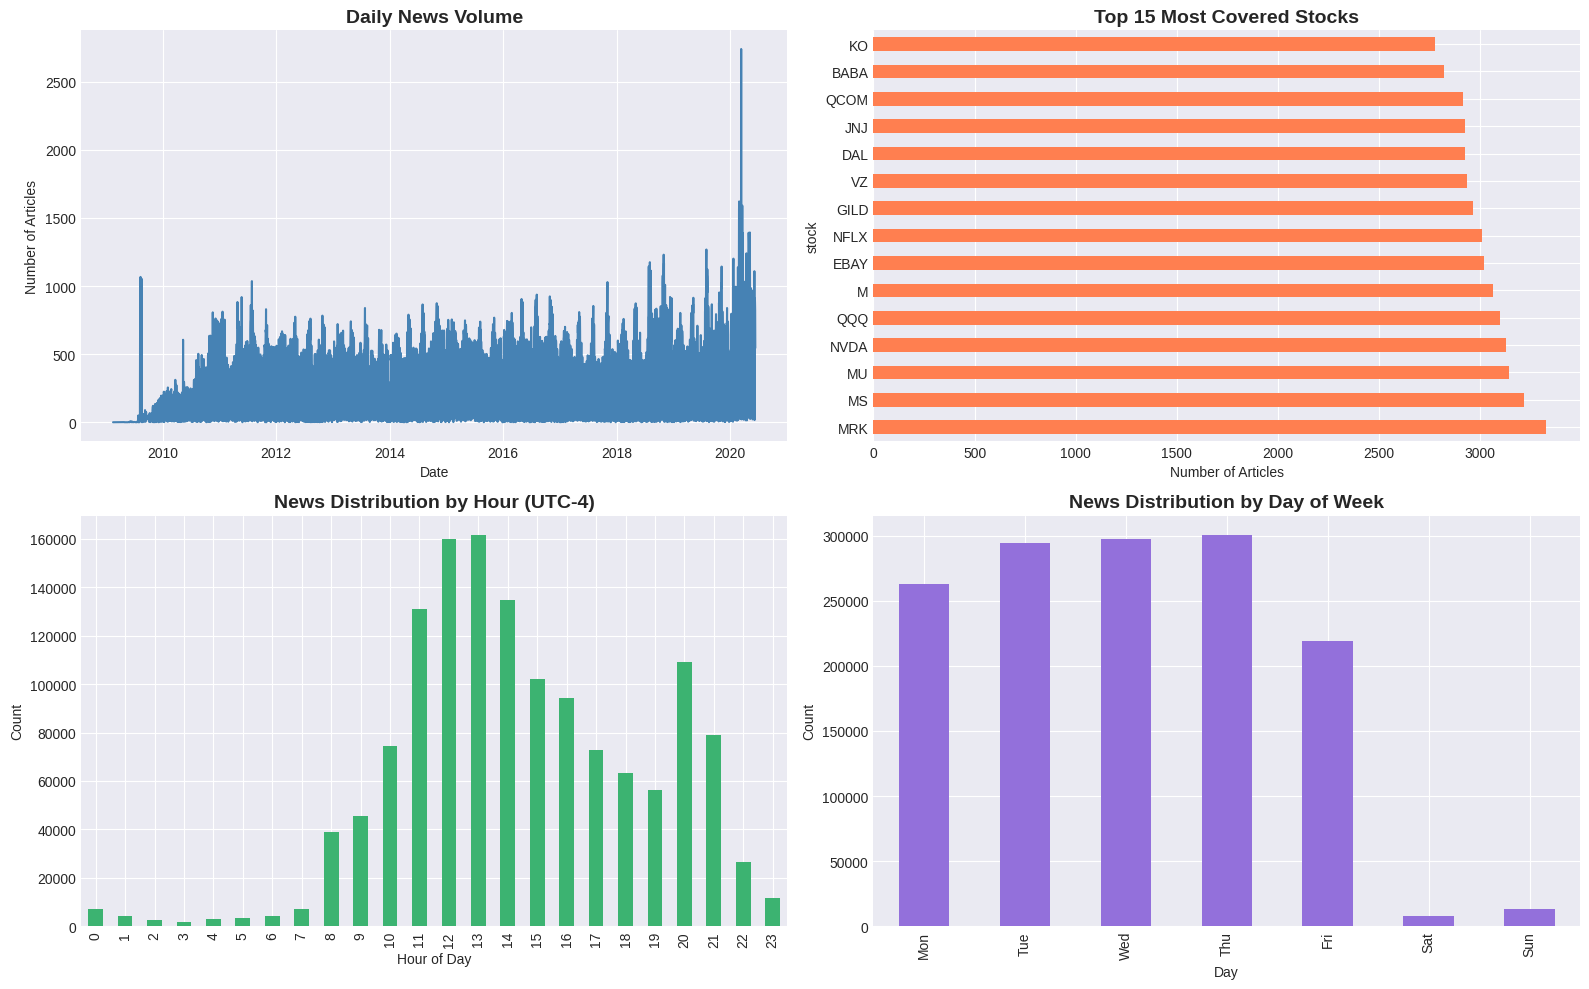

In [8]:
# Temporal analysis
df_clean['date'] = pd.to_datetime(df_clean['date'], errors = 'coerce') # Ensure 'date' column is datetime
df_clean = df_clean.dropna(subset = ['date']) # Remove rows where date conversion failed and became NaT

df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['hour'] = df_clean['date'].dt.hour
df_clean['dayofweek'] = df_clean['date'].dt.dayofweek

# Create comprehensive EDA
fig, axes = plt.subplots(2, 2, figsize = (16, 10))

# News volume over time
df_clean.groupby(df_clean['date'].dt.date).size().plot(ax = axes[0,0], color = 'steelblue')
axes[0,0].set_title('Daily News Volume', fontsize = 14, fontweight = 'bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Number of Articles')

# Top 15 stocks by news coverage
stock_counts = df_clean['stock'].value_counts().head(15)
stock_counts.plot(kind = 'barh', ax = axes[0,1], color = 'coral')
axes[0,1].set_title('Top 15 Most Covered Stocks', fontsize = 14, fontweight = 'bold')
axes[0,1].set_xlabel('Number of Articles')

# Intraday distribution
df_clean['hour'].value_counts().sort_index().plot(kind = 'bar', ax = axes[1,0], color = 'mediumseagreen')
axes[1,0].set_title('News Distribution by Hour (UTC-4)', fontsize = 14, fontweight = 'bold')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Count')

# Day of week pattern
dayofweek_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_clean['dayofweek'].map(dayofweek_map).value_counts().reindex(dayofweek_map.values()).plot(
    kind = 'bar', ax=axes[1,1], color = 'mediumpurple'
)
axes[1,1].set_title('News Distribution by Day of Week', fontsize = 14, fontweight = 'bold')
axes[1,1].set_xlabel('Day')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

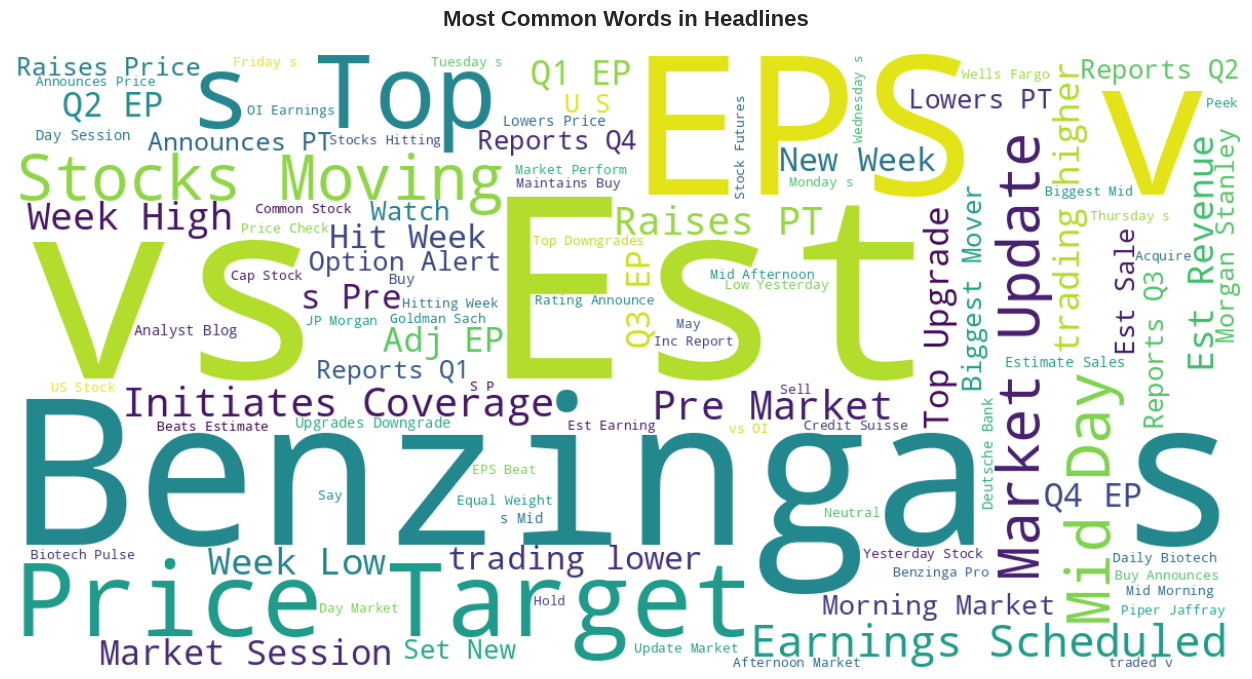

In [9]:
# Word cloud of most common words in headlines
all_headlines = ' '.join(df_clean['title_clean'].astype(str))
wordcloud = WordCloud(width = 1200, height = 600, background_color = 'white', 
                      colormap = 'viridis', max_words = 100).generate(all_headlines)

plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Most Common Words in Headlines', fontsize = 16, fontweight = 'bold', pad = 20)
plt.show()

# **Sentiment Scoring of Financial Texts**

In this step, we apply a pre-trained sentiment model to cleaned news headlines
to quantify the **market tone embedded in textual information**.

Each headline is mapped into:
- A dominant sentiment label
- A confidence score
- Class-level probabilities (negative, neutral, positive)

This granular representation allows sentiment to be used not only as a categorical
signal, but also as a **continuous decision variable**.

In [10]:
class FinBERTSentimentAnalyzer:
    """
    FinBERT Sentiment Analyzer (Optimized for Batch Processing)
    Uses GPU acceleration to classify financial text into Positive, Negative, or Neutral.
    """

    def __init__(self, model_name = 'ProsusAI/finbert'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device set to: {self.device}")
        print(f"Loading FinBERT model: {model_name}...")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.device)
        self.model.eval() 
    def predict_batch(self, texts, batch_size=32):
        """
        True batch processing for high-speed inference.
        """
        all_probs = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc = f"Analyzing {len(texts)} headlines"):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenization 
            inputs = self.tokenizer(
                batch_texts, 
                return_tensors = "pt", 
                padding = True, 
                truncation = True, 
                max_length = 64
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Logits -> Probabilities (Softmax)
                probs = F.softmax(outputs.logits, dim = 1)
                all_probs.append(probs.cpu())
                
            if self.device.type == 'cuda':
                torch.cuda.empty_cache()

        return torch.cat(all_probs).numpy()

# Initialisation
analyzer = FinBERTSentimentAnalyzer()

# Data Check (using df from the Processor step)
if 'title_clean' not in df_clean.columns:
    raise ValueError("Error: 'title_clean' column not found. Please run the data cleaning step first.")

print("\nStarting Sentiment Analysis Pipeline...")
texts = df_clean['title_clean'].tolist()

# Prediction
sentiment_probs = analyzer.predict_batch(texts, batch_size = 64)

# Processing Results into DataFrame
# FinBERT output order: [Positive, Negative, Neutral] (May vary from model to model; for ProsusAI it is generally Pos, Neg, Neu order, but config check may be required. 
# ProsusAI/Finbert config.id2label: {0: “positive”, 1: “negative”, 2: “neutral”}
df_clean['sentiment_positive'] = sentiment_probs[:, 0]
df_clean['sentiment_negative'] = sentiment_probs[:, 1]
df_clean['sentiment_neutral'] = sentiment_probs[:, 2]

# Compound Score: Between +1 (Fully Positive) and -1 (Fully Negative)
# Formula: Positive - Negative
df_clean['sentiment_score'] = df_clean['sentiment_positive'] - df_clean['sentiment_negative']

# Assign labels (based on highest probability)
labels = ['positive', 'negative', 'neutral']
df_clean['sentiment_label'] = [labels[np.argmax(x)] for x in sentiment_probs]

print("Analysis Complete.")

# Sample Results Display
print("\nSample Results:")
display(df_clean[['title', 'sentiment_label', 'sentiment_score', 'sentiment_positive']].head())

Device set to: cuda
Loading FinBERT model: ProsusAI/finbert...


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2026-02-03 16:12:02.362439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770135122.553626      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770135122.610630      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770135123.061604      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770135123.061637      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770135123.061640      55 computation_placer.cc:177] computation placer alr

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]


Starting Sentiment Analysis Pipeline...


Analyzing 1395031 headlines:   0%|          | 0/21798 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Analysis Complete.

Sample Results:


,title,sentiment_label,sentiment_score,sentiment_positive
0,Stocks That Hit 52-Week Highs On Friday,neutral,0.129437,0.211447
1,Stocks That Hit 52-Week Highs On Wednesday,neutral,0.191987,0.261657
2,71 Biggest Movers From Friday,neutral,-0.014934,0.094137
3,46 Stocks Moving In Friday's Mid-Day Session,neutral,-0.107291,0.043411
4,B of A Securities Maintains Neutral on Agilent...,positive,0.582008,0.602363


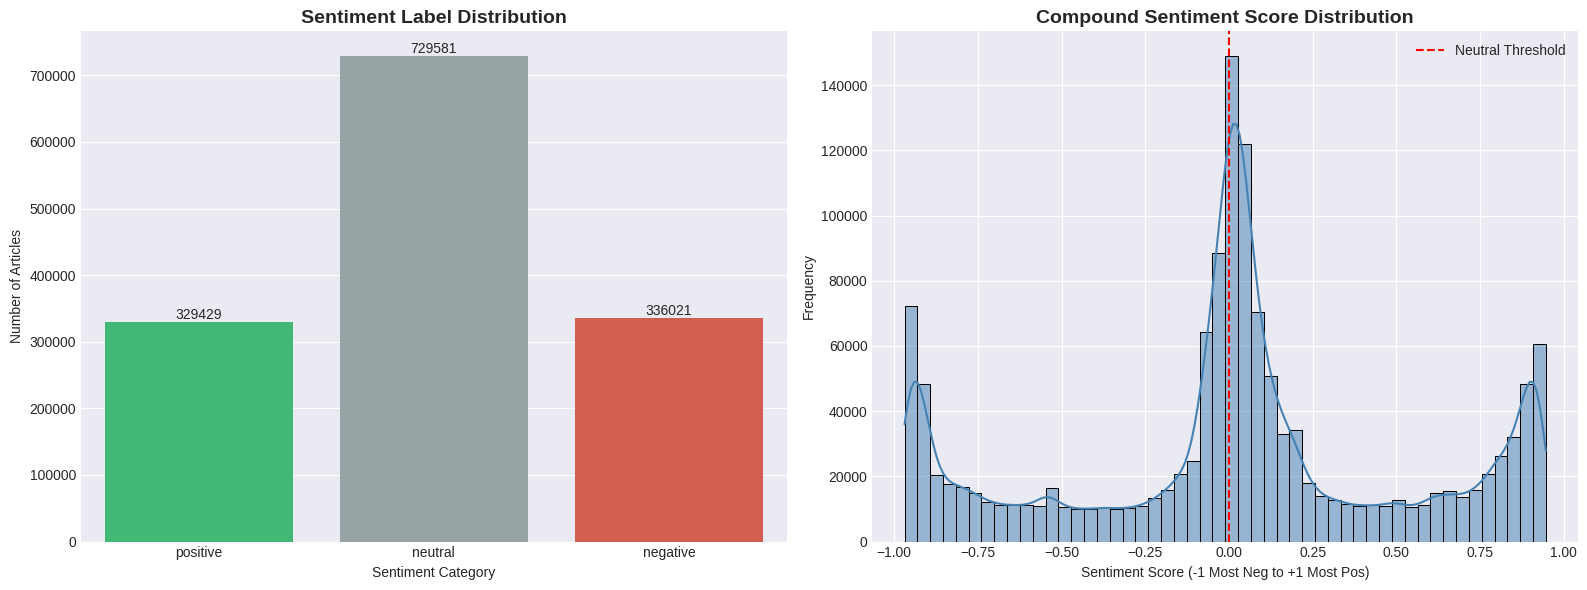

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Chart: Sentiment Distribution (Bar Chart)
# Fix colours: Positive=Green, Negative=Red, Neutral=Grey
custom_palette = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#95a5a6'}

sns.countplot(x='sentiment_label', data = df_clean, order = ['positive', 'neutral', 'negative'], 
              palette = custom_palette, ax = axes[0])

axes[0].set_title('Sentiment Label Distribution', fontsize = 14, fontweight = 'bold')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Number of Articles')

for container in axes[0].containers:
    axes[0].bar_label(container)

# Graph: Sentiment Score Distribution (Histogram)
# In the previous step, we saved it as 'sentiment_score'
sns.histplot(df_clean['sentiment_score'], bins = 50, kde = True, color = 'steelblue', ax = axes[1])

axes[1].axvline(x = 0, color = 'red', linestyle = '--', label = 'Neutral Threshold')
axes[1].set_title('Compound Sentiment Score Distribution', fontsize = 14, fontweight = 'bold')
axes[1].set_xlabel('Sentiment Score (-1 Most Neg to +1 Most Pos)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

# **Stock Price Data Integration**

To evaluate market impact, sentiment signals must ultimately be linked to asset price movements.

In a production setting, this step would involve:
- Fetching historical price data (e.g., via yfinance),
- Computing returns aligned with news timestamps,
- Ensuring strict temporal causality.

In this notebook, the structure is demonstrated conceptually, with placeholders indicating where real market data should be integrated.


In [13]:
def fetch_market_data(tickers, start_date, end_date):
    """
    Fetches historical stock data and calculates daily returns.
    Optimized for batch processing with yfinance.
    """
    print(f"Fetching data for {len(tickers)} tickers from {start_date} to {end_date}...")
    
    try:
        market_data = yf.download(
            tickers, 
            start = start_date, 
            end = end_date, 
            group_by = 'ticker', 
            auto_adjust = True,
            progress = True,
            threads = True 
        )
        
        # Organising the data structure (Wide Format -> Long Format)
        # Columns (Ticker, OHLC)
        if len(tickers) > 1:
            market_data = market_data.stack(level = 0).reset_index()
            market_data.rename(columns = {'level_1': 'ticker'}, inplace = True)
        else:
            market_data['ticker'] = tickers[0]
            market_data = market_data.reset_index()

        # Standardising column names
        market_data.columns = [c.lower() for c in market_data.columns]
        
        # Daily Log Return Calculation
        # Log Return is more robust than Simple Return in financial modelling
        market_data['log_return'] = np.log(market_data['close'] / market_data['close'].shift(1))
        
        # Target Variable: Has the price increased? (1: Yes, 0: No)
        market_data['target_direction'] = (market_data['log_return'] > 0).astype(int)
        
        print("Market data fetch complete.")
        return market_data
        
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

top_stocks = df_clean['stock'].value_counts().head(10).index.tolist()

start_date = df_clean['date'].min().strftime('%Y-%m-%d')
end_date = (df_clean['date'].max() + pd.Timedelta(days = 1)).strftime('%Y-%m-%d')

print(f"Target Stocks: {top_stocks}")
print(f"Date Range: {start_date} to {end_date}")

df_market = fetch_market_data(top_stocks, start_date, end_date)

if df_market is not None:
    print(f"\nMarket Data Shape: {df_market.shape}")
    display(df_market[['date', 'ticker', 'close', 'log_return', 'target_direction']].head())
    
    df_clean['date'] = pd.to_datetime(df_clean['date']).dt.tz_convert(None) 

Target Stocks: ['MRK', 'MS', 'MU', 'NVDA', 'QQQ', 'M', 'EBAY', 'NFLX', 'GILD', 'VZ']
Date Range: 2009-02-14 to 2020-06-12
Fetching data for 10 tickers from 2009-02-14 to 2020-06-12...


[*********************100%***********************]  10 of 10 completed


Market data fetch complete.

Market Data Shape: (28500, 9)


,date,ticker,close,log_return,target_direction
0,2009-02-17,EBAY,4.614622,NaN,0
1,2009-02-17,GILD,16.924143,1.299511,1
2,2009-02-17,M,4.594708,-1.303836,0
3,2009-02-17,MRK,15.116168,1.190860,1
4,2009-02-17,MS,13.810492,-0.090336,0


# **Sentiment Aggregation & Feature Engineering**

Individual news headlines are sparse and noisy.  
To extract stable signals, sentiment scores are aggregated across multiple time horizons.

This section constructs:
- Statistical summaries of sentiment intensity,
- Lagged features capturing delayed market reactions,
- Rolling-window features representing sentiment momentum.

These engineered features form the input space for both statistical testing and deep learning models.

In [14]:
class SentimentAggregator:
    """
    Aggregates sentiment scores into time-series features for stock prediction.
    Handles data resampling and feature generation (lags, rolling averages).
    """
    
    def __init__(self, df):
        self.df = df.copy()
        # Ensure date is in standard UTC datetime format
        if 'date' in self.df.columns:
            self.df['date'] = pd.to_datetime(self.df['date'], utc = True)
        self.df = self.df.sort_values('date')
    
    def aggregate_by_stock_and_period(self, stock, period = 'D'):
        """
        Aggregate sentiment for a specific stock over a given time period.
        
        Args:
            stock (str): Ticker symbol (e.g., 'AAPL')
            period (str): Resampling frequency ('D'=Daily, 'H'=Hourly)
        """
        # Filter data for the specific stock
        stock_df = self.df[self.df['stock'] == stock].copy()
        
        if stock_df.empty:
            print(f"Warning: No data found for stock {stock}")
            return None
        
        # Set date as index for resampling
        stock_df = stock_df.set_index('date')
        
        # Define aggregation dictionary
        # CRITICAL FIX: Using 'sentiment_score' instead of 'sentiment_compound'
        agg_dict = {
            'sentiment_score': ['mean', 'std', 'min', 'max', 'count'],
            'sentiment_positive': 'mean',
            'sentiment_negative': 'mean',
            'sentiment_neutral': 'mean'
        }
        
        # Resample and aggregate
        aggregated = stock_df.resample(period).agg(agg_dict)
        
        # Flatten multi-level columns (e.g., 'sentiment_score_mean')
        aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]
        
        # Rename columns for clarity
        aggregated = aggregated.rename(columns={
            'sentiment_score_mean': 'sentiment_mean',
            'sentiment_score_std': 'sentiment_std',
            'sentiment_score_min': 'sentiment_min',
            'sentiment_score_max': 'sentiment_max',
            'sentiment_score_count': 'news_count'
        })
        
        # Fill missing values (days with no news are considered neutral)
        aggregated = aggregated.fillna(0)
        
        return aggregated
    
    def create_lag_features(self, df, lags = [1, 2, 3]):
        """
        Create lagged features to capture past sentiment influence.
        Lag 1 = Yesterday's sentiment.
        """
        for lag in lags:
            df[f'sentiment_lag_{lag}'] = df['sentiment_mean'].shift(lag)
        return df
    
    def create_rolling_features(self, df, windows = [3, 7]):
        """
        Create rolling window statistics (Moving Averages).
        Captures trends over 3 days, 7 days, etc.
        """
        for window in windows:
            df[f'sentiment_ma_{window}'] = df['sentiment_mean'].rolling(window).mean()
            df[f'sentiment_std_{window}'] = df['sentiment_mean'].rolling(window).std()
        return df

In [15]:
# Find the stock with the most news coverage
top_stock = df_clean['stock'].value_counts().idxmax()
print(f"Aggregating sentiment for top stock: {top_stock}")

# Initialize Aggregator
aggregator = SentimentAggregator(df_clean)

# Aggregate data on a Daily ('D') basis
daily_sentiment = aggregator.aggregate_by_stock_and_period(top_stock, period = 'D')

# Generate Technical Features (Lags & Rolling Windows)
daily_sentiment = aggregator.create_lag_features(daily_sentiment, lags = [1, 2, 3])
daily_sentiment = aggregator.create_rolling_features(daily_sentiment, windows = [3, 7])

print("\nAggregated Sentiment Features (Head):")
# Drop the first few rows containing NaNs due to lag creation
display(daily_sentiment.dropna().head(10))

Aggregating sentiment for top stock: MRK

Aggregated Sentiment Features (Head):


,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,news_count,sentiment_positive_mean,sentiment_negative_mean,sentiment_neutral_mean,sentiment_lag_1,sentiment_lag_2,sentiment_lag_3,sentiment_ma_3,sentiment_std_3,sentiment_ma_7,sentiment_std_7
date,,,,,,,,,,,,,,,
2009-08-02 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001455,0.003849
2009-08-03 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-08-04 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-08-05 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-08-06 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-08-07 00:00:00+00:00,0.004689,0.0,0.004689,0.004689,1,0.029559,0.024870,0.945571,0.000000,0.000000,0.000000,0.001563,0.002707,0.000670,0.001772
2009-08-08 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.004689,0.000000,0.000000,0.001563,0.002707,0.000670,0.001772
2009-08-09 00:00:00+00:00,0.000000,0.0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.004689,0.000000,0.001563,0.002707,0.000670,0.001772
2009-08-10 00:00:00+00:00,-0.000378,0.0,-0.000378,-0.000378,1,0.028200,0.028578,0.943222,0.000000,0.000000,0.004689,-0.000126,0.000218,0.000616,0.001801


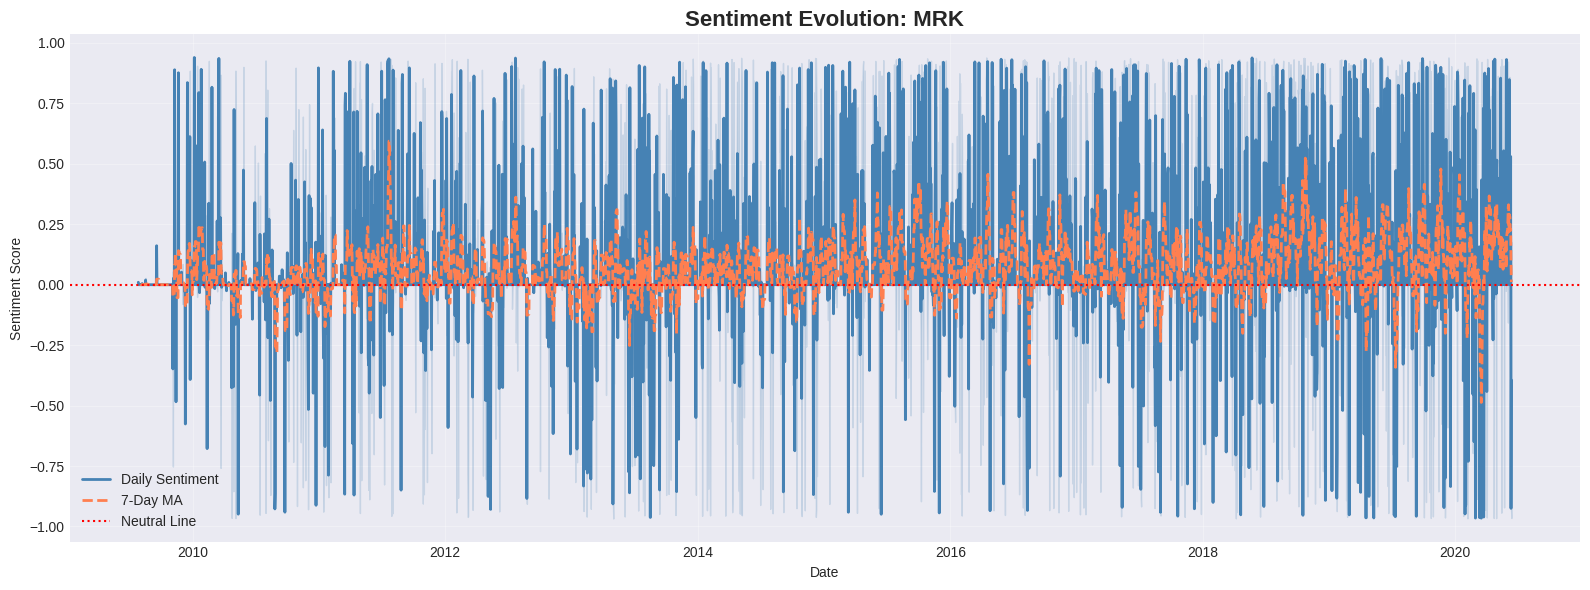

In [16]:
# Visualize sentiment evolution
plt.figure(figsize = (16, 6))
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_mean'], 
         label = 'Daily Sentiment', linewidth = 2, color = 'steelblue')
plt.plot(daily_sentiment.index, daily_sentiment['sentiment_ma_7'], 
         label = '7-Day MA', linewidth = 2, linestyle = '--', color = 'coral')
plt.axhline(y = 0, color = 'red', linestyle = ':', label = 'Neutral Line')
plt.fill_between(daily_sentiment.index, 
                 daily_sentiment['sentiment_min'], 
                 daily_sentiment['sentiment_max'], 
                 alpha=0.2, color='steelblue')
plt.title(f'Sentiment Evolution: {top_stock}', fontsize = 16, fontweight = 'bold')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

# **Statistical Analysis: Sentiment–Return Relationship**

Before applying complex models, it is essential to establish whether sentiment exhibits any statistical association with returns.

The analysis framework includes:
- Pearson and Spearman correlation tests,
- Quintile-based portfolio comparisons,
- Granger causality tests to assess predictive directionality.

This step distinguishes genuine signal from spurious correlation and grounds the study in empirical finance principles.


--- Statistical Analysis for MRK ---
Fetching market data...
Data Points after merging: 2738

1. Correlation Tests:
   Pearson  (Linear): 0.1194 (p-value: 0.0000)
   Spearman (Rank)  : 0.1120 (p-value: 0.0000)

2. Quantile Analysis (Avg Daily Return %):
quantile
1   -0.071101
2    0.283034
3    0.205482
Name: returns, dtype: float64


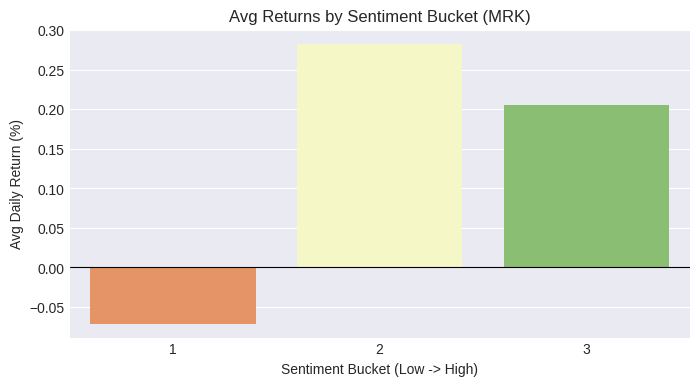


3. Granger Causality Test (Sentiment -> Returns):
   Lag 1: p-value = 0.0928 
   Lag 2: p-value = 0.1479 
   Lag 3: p-value = 0.1689 


In [17]:
def analyze_sentiment_return_correlation(sentiment_df, stock_symbol):
    """
    Performs statistical analysis to validate the relationship between 
    news sentiment and stock returns.
    """
    print(f"--- Statistical Analysis for {stock_symbol} ---")
    
    # Fetch Market Data
    print("Fetching market data...")
    start_date = sentiment_df.index.min().strftime('%Y-%m-%d')
    end_date = (sentiment_df.index.max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
    
    try:
        price_data = yf.download(stock_symbol, start = start_date, end = end_date, progress = False, auto_adjust = True)
        
        # Flatten MultiIndex columns if necessary
        if isinstance(price_data.columns, pd.MultiIndex):
            price_data.columns = price_data.columns.get_level_values(0)

        # Calculate Log Returns
        price_data['returns'] = np.log(price_data['Close'] / price_data['Close'].shift(1))
        
        # Adjust Timezone
        if price_data.index.tz is None:
            price_data.index = price_data.index.tz_localize('UTC')
        else:
            price_data.index = price_data.index.tz_convert('UTC')
            
    except Exception as e:
        print(f"Error fetching market data: {e}")
        return None

    # Merge Sentiment and Returns
    merged = sentiment_df[['sentiment_mean']].join(price_data[['returns']], how='inner').dropna()
    
    print(f"Data Points after merging: {len(merged)}")
    if len(merged) < 10:
        print("Not enough data for statistical analysis.")
        return None

    # Correlation Analysis
    p_corr, p_val = pearsonr(merged['sentiment_mean'], merged['returns'])
    s_corr, s_val = spearmanr(merged['sentiment_mean'], merged['returns'])
    
    print("\n1. Correlation Tests:")
    print(f"   Pearson  (Linear): {p_corr:.4f} (p-value: {p_val:.4f})")
    print(f"   Spearman (Rank)  : {s_corr:.4f} (p-value: {s_val:.4f})")
    
    # Quantile Analysis (Portfolio Simulation)
    try:
        merged['quantile'] = pd.qcut(merged['sentiment_mean'], 5, labels = False, duplicates = 'drop')
        # Add 1 to make it 1-based (Bucket 1, Bucket 2, etc.)
        merged['quantile'] = merged['quantile'] + 1
        
        quantile_returns = merged.groupby('quantile')['returns'].mean() * 100 
        
        print("\n2. Quantile Analysis (Avg Daily Return %):")
        print(quantile_returns)
        
        # Visualize
        plt.figure(figsize = (8, 4))
        sns.barplot(x = quantile_returns.index, y = quantile_returns.values, palette = 'RdYlGn')
        plt.title(f'Avg Returns by Sentiment Bucket ({stock_symbol})')
        plt.xlabel('Sentiment Bucket (Low -> High)')
        plt.ylabel('Avg Daily Return (%)')
        plt.axhline(0, color = 'black', linewidth = 0.8)
        plt.show()
        
    except Exception as e:
        print(f"\nCould not perform quantile analysis (likely insufficient variance): {e}")

    # Granger Causality Test
    print("\n3. Granger Causality Test (Sentiment -> Returns):")
    max_lag = 3
    test_result = grangercausalitytests(merged[['returns', 'sentiment_mean']], maxlag = max_lag, verbose = False)
    
    for lag in range(1, max_lag + 1):
        p_value = test_result[lag][0]['ssr_ftest'][1]
        is_significant = "*" if p_value < 0.05 else ""
        print(f"   Lag {lag}: p-value = {p_value:.4f} {is_significant}")

    return merged


if 'daily_sentiment' in locals() and 'top_stock' in locals():
    stats_df = analyze_sentiment_return_correlation(daily_sentiment, top_stock)
else:
    print("Please run the 'Feature Engineering' step first.")

# **Deep Learning Model: LSTM for Time-Series Prediction**

Financial sentiment evolves over time and may influence prices with delays.  
To model these dynamics, we employ an **Attention-based LSTM network**.

Key advantages:
- LSTM layers capture long-range temporal dependencies,
- Attention mechanisms highlight which time steps matter most,
- The architecture balances predictive power with interpretability.

The model outputs a continuous prediction representing sentiment-adjusted return expectations.

Merging features and targets...
Data ready. Train shape: (2179, 10, 6), Test shape: (545, 10, 6)
Model Parameters: 210,178

Starting Training...
Epoch [10/50], Loss: 0.6927
Epoch [20/50], Loss: 0.6904
Epoch [30/50], Loss: 0.6780
Epoch [40/50], Loss: 0.6523
Epoch [50/50], Loss: 0.6098


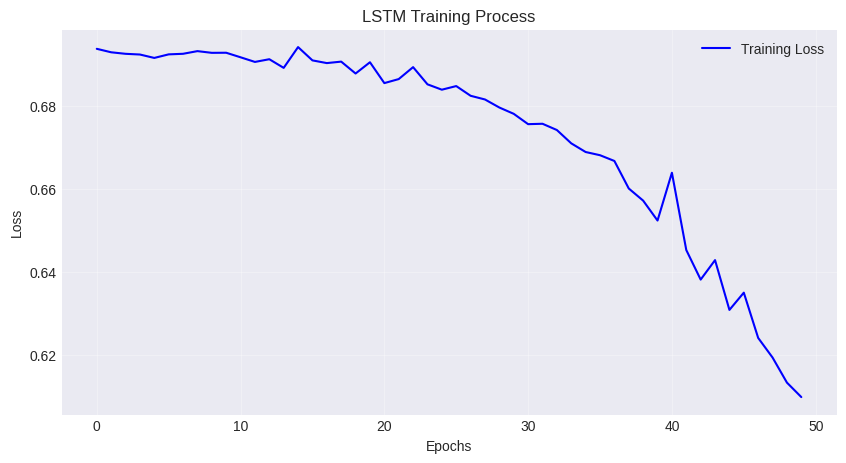


--- Test Results ---
Accuracy: 52.66%

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.50       255
           1       0.56      0.55      0.55       290

    accuracy                           0.53       545
   macro avg       0.53      0.53      0.53       545
weighted avg       0.53      0.53      0.53       545



In [18]:
# Model Architecture (Attention Mechanism)
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size = 128, num_layers = 2, dropout = 0.3):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0
        )
        self.attention = nn.Linear(hidden_size, 1)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim = 1)
        context_vector = torch.sum(attn_weights * lstm_out, dim = 1)
        out = self.fc1(context_vector)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out, attn_weights

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

if 'daily_sentiment' in locals() and 'stats_df' in locals():
    print("Merging features and targets...")
    
    # daily_sentiment: All features are here
    # stats_df: Target variable (returns) is here
    # Matching dates using inner join
    full_data = daily_sentiment.join(stats_df[['returns']], how = 'inner').dropna()
    
    features = ['sentiment_mean', 'sentiment_std', 'news_count', 
                'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_ma_3']
    
    X_raw = full_data[features].values
    y_raw = (full_data['returns'] > 0).astype(int).values # Binary Target
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    
    SEQ_LENGTH = 10
    X, y = create_sequences(X_scaled, y_raw, SEQ_LENGTH)
    
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device))
    test_dataset = TensorDataset(torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device))
    
    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)
    print(f"Data ready. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

def train_model(model, train_loader, epochs = 50):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_history = []
    
    print("\nStarting Training...")
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
            
    return loss_history

if 'train_loader' in locals():
    input_size = len(features)
    model = AttentionLSTM(input_size=input_size).to(device)
    
    print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    losses = train_model(model, train_loader, epochs=50)

    plt.figure(figsize = (10, 5))
    plt.plot(losses, label = 'Training Loss', color = 'blue')
    plt.title('LSTM Training Process')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.show()

    model.eval()
    with torch.no_grad():
        test_inputs = torch.FloatTensor(X_test).to(device)
        test_preds, attn_weights = model(test_inputs)
        y_pred_binary = (test_preds.cpu().squeeze() > 0.5).float()
        
    print("\n--- Test Results ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_binary):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))

# **Performance Evaluation & Strategy Backtesting**

To assess whether sentiment-driven signals translate into **economic value**,
we evaluate the strategy using a custom backtesting framework.

The focus is not only on returns, but also on **risk exposure, trading costs,
and drawdown behavior**, reflecting realistic trading conditions.

Initializing Backtest with Real Test Data...

--- Backtesting Results ---
Total Return: -5.66%
Benchmark Return: 34.63%
Win Rate: 28.26%
Sharpe Ratio: -0.0468
Max Drawdown: -29.65%


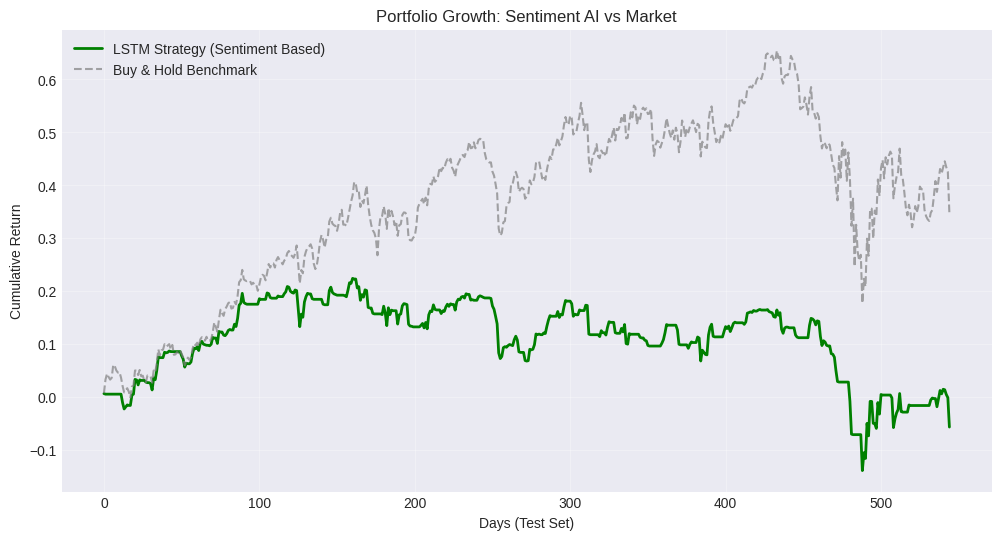

In [19]:
class TradingBacktester:
    """
    Backtest trading strategies based on model predictions vs actual returns.
    """
    
    def __init__(self, signals, returns, transaction_cost = 0.001):
        # Balancing the size of signals and returns
        min_len = min(len(signals), len(returns))
        self.signals = np.array(signals[:min_len])
        self.returns = np.array(returns[:min_len])
        self.transaction_cost = transaction_cost
        
    def calculate_metrics(self):
        # Strategy Return: Signal (1 or 0) * Actual Return
        # If Signal is 0 (Sell/Hold), the return is 0.
        # If Signal is 1 (Buy), take the stock return for that day.
        strategy_returns = self.signals * self.returns
        
        # Transaction Cost (Payable when the position changes)
        trades = np.abs(np.diff(self.signals, prepend = 0))
        costs = trades * self.transaction_cost
        
        net_strategy_returns = strategy_returns - costs
        
        # Benchmark (Buy and Hold Strategy)
        cumulative_benchmark = np.cumprod(1 + self.returns) - 1
        cumulative_strategy = np.cumprod(1 + net_strategy_returns) - 1
        
        # Metrics
        total_return = cumulative_strategy[-1]
        win_rate = np.mean(net_strategy_returns > 0)
        
        # Sharpe Ratio (Annualised, assuming a risk-free interest rate of 0)
        if np.std(net_strategy_returns) > 0:
            sharpe = (np.mean(net_strategy_returns) / np.std(net_strategy_returns)) * np.sqrt(252)
        else:
            sharpe = 0
            
        # Max Drawdown
        cum_ret_series = pd.Series(cumulative_strategy)
        running_max = cum_ret_series.expanding().max()
        drawdown = (cum_ret_series - running_max) / (1 + running_max)
        max_drawdown = drawdown.min()
        
        return {
            'Total Return': total_return,
            'Benchmark Return': cumulative_benchmark[-1],
            'Win Rate': win_rate,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_drawdown
        }, cumulative_strategy, cumulative_benchmark

    def plot_performance(self, cum_strategy, cum_benchmark):
        plt.figure(figsize = (12, 6))
        plt.plot(cum_strategy, label = 'LSTM Strategy (Sentiment Based)', color = 'green', linewidth = 2)
        plt.plot(cum_benchmark, label = 'Buy & Hold Benchmark', color = 'gray', linestyle = '--', alpha = 0.7)
        
        plt.title('Portfolio Growth: Sentiment AI vs Market')
        plt.xlabel('Days (Test Set)')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True, alpha = 0.3)
        plt.show()

print("Initializing Backtest with Real Test Data...")

test_real_returns = full_data['returns'].iloc[-len(y_pred_binary):].values

model_signals = y_pred_binary.cpu().numpy()

backtester = TradingBacktester(signals=model_signals, returns=test_real_returns)

metrics, cum_strat, cum_bench = backtester.calculate_metrics()

print("\n--- Backtesting Results ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if k == 'Sharpe Ratio' else f"{k}: {v:.2%}")

backtester.plot_performance(cum_strat, cum_bench)